<a href="https://colab.research.google.com/github/John-Dennis-AI/How-to-build-own-text-summarizer-using-deep-learning/blob/master/Abstractive_Text_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstractive Text Summarizer

This notebook demonstrates the concept of text abstraction for summarizing an article. ***Abstraction*** differs from ***extraction*** in that the former method uses context to produce a new summary as opposed to the latter method that uses exact words and phrases from the original article. Abstraction is not necessarily a subset of the original text, but extraction is a subset of the original text.

In this notebook, we will build a deep learning text abstraction model using Python and Keras to generate a summary from the Amazon Fine Food reviews. If you are interested, you can download the dataset from [here](https://www.kaggle.com/snap/amazon-fine-food-reviews).

The original text reviews are the source and the original summaries are the target. The model builds "vocabulary dictionaries" out of both the text reviews and the summaries, and then learns from observation how to construct a summary given a text review so that it can operate on unseen text reviews by tapping into the original summary vocabulary dictionary. The model looks for certain key words in the text reviews, then it goes to the summary vocabulary dictionary and finds the word with the highest probability of being the next word and produces that word to build a predicted summary.

**Significant credit for this notebook goes to the original author for his wonderful work**, located [here](https://colab.research.google.com/github/aravindpai/How-to-build-own-text-summarizer-using-deep-learning/blob/master/How_to_build_own_text_summarizer_using_deep_learning.ipynb).

I made my own edits and modifications as part of my ongoing learning process, which includes the following items:

*   The alteration of the embedding layers to the Encoder
*   Code updates to satisfy Python requirements
*   Several updates to notes and comments throughout for added clarity
*   The addition of a BLEU score to measure model performance

I used a GPU for model development, but you can experiment with a CPU, GPU, or TPU to see what works best for you.

#Using a Custom Attention Layer

Attention layers are helpful for text summarization. They take a small sample of words from a long sentence and summarize it, then they take another sample, and so on. They use vectors to find relationships between words, assign a relevancy, and ignore the less relevant words. Keras does not officially support attention layers, so we are borrowing some code to implement it. Credit for the original work and code is located [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py).

Here's where we import the attention layer into our environment:

In [1]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

#Import the Libraries

In [2]:
import numpy as np              #performs fast matrix math
import pandas as pd             #data analysis library that uses data frames (similar to spreadsheets)
import re                       #library for regular expressions
from bs4 import BeautifulSoup   #BeautifulSoup is a parsing package
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from nltk.translate.bleu_score import sentence_bleu  #used for calculating BLEU score
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


#Read the Dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text reviews, and summaries. We'll be focusing on the text reviews and summaries.

We’ll take a sample of 25,000 reviews to reduce the training time of our model.

In [0]:
#if using Google Colab, files are stored in the default files folder (file icon in left pane)
#files must be uploaded every time there is a new run

data=pd.read_csv("Reviews.csv",nrows=25000)

# Remove Duplicates and NA Values
Here is where we do some initial basic data cleaning. We remove duplicates and invalid values.

In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)  #remove duplicates
data.dropna(axis=0,inplace=True)                    #remove na values

# Information about the Dataset

Now let's take a look at the datatypes and the shape of the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24164 entries, 0 to 24999
Data columns (total 10 columns):
Id                        24164 non-null int64
ProductId                 24164 non-null object
UserId                    24164 non-null object
ProfileName               24164 non-null object
HelpfulnessNumerator      24164 non-null int64
HelpfulnessDenominator    24164 non-null int64
Score                     24164 non-null int64
Time                      24164 non-null int64
Summary                   24164 non-null object
Text                      24164 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


#Preprocessing the Data

In this step, we continue to clean the data by removing all the unwanted symbols, characters, etc. from the text that will have no impact on our desired results. In particular, this is the dictionary that we will use for expanding contractions.

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

#And More Preprocessing of the Data

Here, we continue to clean up the data by doing the following:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

And here's the function:

In [7]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:               #here we remove short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#now call the text_cleaner function on the Text field
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let's take a look at the first ten preprocessed reviews.

In [9]:
cleaned_text[:10]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband l

In [0]:
#call the text_cleaner function on the Summary field
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let's take a look at the first 10 preprocessed summaries.

In [11]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Remove the Empty Rows

In [0]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

#Understanding the Distribution of the Sequences

Here, we analyze the length of the reviews and the summary to get an idea of the distribution of the length of the text. This will help us determine the maximum length of the sequence.

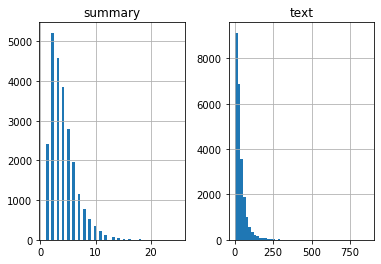

In [14]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 50) #more bins per graph is more granular
plt.show()

It appears that the majority of summaries are less than a length of 8, so that would make a reasonable cutoff point.

Just for fun, let's see the percentage of summaries with a length less than or equal to 8.

In [15]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.941963545981773


We've confirmed that 94% of the summaries have a length below 8.

Looking at the graph, it seems that 50 is a reasonable cutoff for the text reviews. Let's test it here.

In [16]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.7776304888152444


We see that a length of 50 gives us nearly 78% of the text reviews. That is more than we need, so we set the text=50 and the summary=8.

In [0]:
max_text_len=50
max_summary_len=8

Let's select the text reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**.

In [0]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Here we add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens.

**Note:** Be sure that the chosen special tokens never appear in the summary, so try to use something unique.

In [0]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

Now we need to split our dataset into a training and validation (testing) set. We’ll use 80% of the dataset as the training data and evaluate the performance on the remaining 20% (holdout set).

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True) 

#Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Here's where we build tokenizers for the text reviews and summaries.

#Text Tokenizer

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences  #pads sequences so they are the same length

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

#Calculating Rare Words in Text Reviews

Let's look at the number of rare words in the text reviews.

Here, I am defining the threshold to be 4 which means a word with a frequency count below 4 is considered to be a rare word.

In [22]:
thresh=4

cnt=0
tot_cnt=0
#freq=0
#tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    #tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        #freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
#print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.95421572125105


**For Reference**:


* **tot_cnt** gives the size of vocabulary (which means every unique word in the text)
 
*   **cnt** gives the number of rare words whose count falls below the threshold

*  **tot_cnt - cnt** gives the top most common words (with rare words removed)

Let's define the tokenizer with the top most common words for text reviews.

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#padding zero up to maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [24]:
x_voc

5895

#Summary Tokenizer

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

#Calculating Rare Words in Summaries

Let's look at the number of rare words in the summaries.

Here, I am defining the threshold to be 6 which means a word with a frequency count below 6 is considered to be a rare word.

In [26]:
thresh=6

cnt=0
tot_cnt=0
#freq=0
#tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    #tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        #freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
#print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.25902668759811


Let's define the tokenizer with the top most common words for summaries.

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

#padding zero up to maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words +1

In [28]:
y_voc

1007

Let's check whether the word count of the start token is equal to length of the training data.

In [29]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(14445, 14445)

Here, we delete the rows that contain only **START** and **END** tokens for both training and validation sets.

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

#Building the Model

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few important terms.

**Return_Sequences = True**: When the return_sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return_State = True**: When return_state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial_State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: This is not a parameter, but a concept. A Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. You may wish to experiment with different multiple layers of the LSTM stacked on top of each other to see what you get.

Here, we are building a 5 layer Stacked LSTM for the encoder.

In [32]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Start of the Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer for the Encoder
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

# Encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

# Encoder lstm 4
encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output4, state_h4, state_c4= encoder_lstm4(encoder_output3)

# Encoder lstm 5
encoder_lstm5=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm5(encoder_output4)

# Start of the Decoder
decoder_inputs = Input(shape=(None,))

# Embedding layer for the Decoder
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Set up the Decoder, using Encoder lstm 5 output as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      589500      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 300), (N 481200      embedding[0][0]                  
_________________________________________________________________________________________

The rmsprop optimizer is a type of gradient descent algorithm. Also, we are using sparse_categorical_crossentropy as the loss function since it converts the integer sequence to a one-hot vector on the fly.

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Here we use early stopping as a regulariziation technique. We will monitor the validation loss (val_loss), and the model will stop training once the validation loss increases.


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 20% of our dataset):

In [35]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 13926 samples, validate on 3446 samples
Epoch 1/50
13926/13926 [==============================] - 79s 6ms/sample - loss: 2.9766 - val_loss: 2.5833
Epoch 2/50
13926/13926 [==============================] - 64s 5ms/sample - loss: 2.5728 - val_loss: 2.5082
Epoch 3/50
13926/13926 [==============================] - 64s 5ms/sample - loss: 2.4784 - val_loss: 2.4137
Epoch 4/50
13926/13926 [==============================] - 63s 5ms/sample - loss: 2.4126 - val_loss: 2.3624
Epoch 5/50
13926/13926 [==============================] - 64s 5ms/sample - loss: 2.3478 - val_loss: 2.3222
Epoch 6/50
13926/13926 [==============================] - 64s 5ms/sample - loss: 2.2869 - val_loss: 2.2818
Epoch 7/50
13926/13926 [==============================] - 64s 5ms/sample - loss: 2.2312 - val_loss: 2.2304
Epoch 8/50
13926/13926 [==============================] - 63s 5ms/sample - loss: 2.1790 - val_loss: 2.2022
E

#Understanding the Loss Plot

Now, we will produce a diagnostic plot to understand the behavior of the model over time.

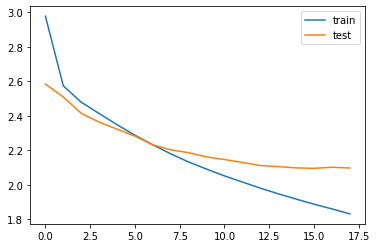

In [36]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation (test) loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for the target and source vocabulary:

In [0]:
reverse_target_word_index=y_tokenizer.index_word    #integers with their words for original summary
reverse_source_word_index=x_tokenizer.index_word    #integers with their words for original text reviews
target_word_index=y_tokenizer.word_index            #a dictionary of words and their uniquely assigned integers for original summary

# Inference

Inference means that we have settled on a model with the best parameters, and now we are ready to run it on new, unseen data. Here, we set up the inference for the encoder and decoder.

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

The function below is the implementation of the inference process.

In [0]:
def decode_sequence(input_seq):
    # Encode the input (text reviews) as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence (summaries) with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        # Here is where the model looks for candidate words
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Build the new summary based on the original summary vocabulary
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let's define the functions to convert an integer sequence to a word sequence for the summaries as well as the text reviews.

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Following are a few summaries generated by the model.

In [41]:
bscore=0
tot_bscore=0

for i in range(0,25):
    print("Original Text Review:",seq2text(x_tr[i]))
    print("Original Summary:",seq2summary(y_tr[i]))
    print("Predicted Summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    references = seq2summary(y_tr[i])
    candidates = decode_sequence(x_tr[i].reshape(1,max_text_len))
    bscore = sentence_bleu(references, candidates)
    tot_bscore += bscore
    print("BLEU score:", bscore)
    print("\n")
  
print("Average of All BLEU Scores:", tot_bscore/(i+1))

Original Text Review: first used cousin germany find us whipped cream stays whipped even next day love 
Original Summary: cream 
Predicted Summary:  great product
BLEU score: 0.7730551756939454


Original Text Review: maybe got litter opened bag foul moldy smell hit face even though label said good doubt food gone bad disappointing 
Original Summary: nuts had gone bad 
Predicted Summary:  great product
BLEU score: 0.8694417438899827


Original Text Review: think one best protein shakes market natural grams protein grams fiber mix light tasting almost refreshing great pre post work meals protein boost great vegetarians soy intolerant love vanilla one chocolate person 
Original Summary: of the best 
Predicted Summary:  great snack
BLEU score: 0.7598356856515925


Original Text Review: husband looking product store nowhere found happy camper 
Original Summary: found them 
Predicted Summary:  great product
BLEU score: 0.8091067115702212


Original Text Review: tried number extra bold cup c

#Next Steps and Ways to Improve the Model’s Performance

**Increase the training dataset** size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size.

Try implementing **Bi-Directional LSTM** which is capable of capturing the context from both the directions and results in a better context vector.

Use the **beam search strategy** for decoding the test sequence instead of using the greedy approach (argmax).

Implement **pointer-generator networks** and **coverage mechanisms**.